# Parameter Estimation with `pymc`

In the previous tutorial, we used a grid search to find the most likely values of two of our chirp signal's parameters. That worked fine, but what if we want to estimate all the parameters of the function together? And maybe do so with a much denser and/or wider grid of values? It quickly becomes computationally problematic.

We will need a smarter way to sample the likelihoods of our parameters. Usually this is done using various Monte Carlo techniques. We will use a Markov Chain Monte Carlo (MCMC) method to perform our parameter estimation. This functionality is conveniently provided by the `pymc` package.

The [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) comes down to choosing random samples from a probability distribution, but choosing them in such a way that the set of samples you end up with approximate the probability distribution. The benefit of this kind of method is that it quickly finds the maximum of the probability distribution and samples mostly around this maximum. The rest of the parameter space is neglected, but we usually do not care.

We will not go into the details of the mathematics behind MCMC, but rather have a look at how we can perform an MCMC sampling in Python to do parameter estimation.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import pymc
import math
import pandas as pd
import seaborn as sns
%matplotlib inline
np.random.seed(0) # For reproducibility

# We will use the same chirp function as previously
def chirp(t, tc, offset, A, dA, f, df):
    """
    Generate a chirp signal.
    
    Arguments:
    t      -- array-like containing the times at which to evaluate the signal.
    tc     -- time of coalescence, after which the signal is terminated; for times beyond tc the signal is set to the constant background.
    offset -- constant background term
    A      -- initial signal amplitude at t=0
    dA     -- linear coefficient describing the increase of the amplitude with time
    f      -- initial signal frequency at t=0
    df     -- linear coefficient describing the increase of the frequency with time
    """
    chirp = offset + (A + dA*t) * np.sin(2*math.pi*(f + df*t) * t)
    chirp[t>tc] = offset
    return chirp

# Let's choose some values for our injected signal
tc_true = 75
offset_true = 30
A_true = 6
dA_true = 0.05
f_true = 0.2
df_true = 0.007

# Noise strength; we will keep it low here so we 
# don't have to run our sampling for too long
sigma = 50

# Time axis
t = np.linspace(0,100,10001)

#y_simple_true = simple_signal(t, offset_true, A_true, f_true, df_true)
#y_simple_obs = np.random.normal(y_simple_true, sigma)

# Injecting our signal into the noise
y_true = chirp(t, tc_true, offset_true, A_true, dA_true, f_true, df_true)
y_obs = np.random.normal(y_true, sigma)

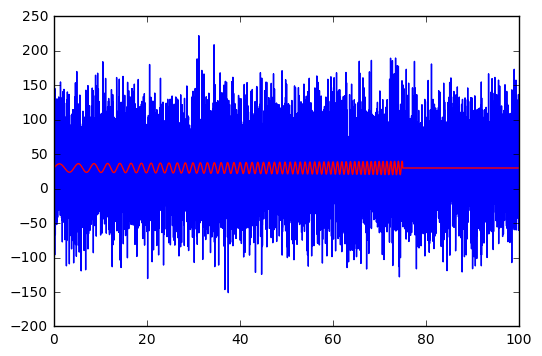

In [10]:
# Let's have alook
plt.plot(t,y_obs)
plt.plot(t,y_true, c='r');

The noise is not as heavy compared to the signal as last time. Smaller signals can be used, but we don't want to have to wait for too long for the MCMC algorithm to run, so we'll keep it simple.

### Setting up `pymc`

[`pymc`](https://pymc-devs.github.io/pymc/) is a package that implements several Bayesian statistical methods, including MCMC. It requires you to build your model by defining all the parameters to be estimated, but then it takes care of all the heavy lifting.

First we need to specify all our parameters as independent stochastic variables.

For each parameter, we specify:
1. The type of prior distribution, i.e. what we know before we start. In this case we assume no prior information, so we just use uniform distributions. In real applications, using prior information, such as the distribution of the masses of black holes or neutron stars in the universe, can be a real benefit; if you are confident enough that you know that distribution.
2. The name of the parameter, used for referencing it later.
3. For a uniform distribution, the range.
4. The initial value, which we choose to be random.

In [11]:
# Helper data to keep track of everything
parameters = ['tc', 'offset', 'A', 'dA', 'f', 'df']
bounds = {'tc' : (0,100), 'offset' : (0,100), 'A' : (0,10), 'dA' : (0,0.1), 'f' : (0,1), 'df' : (0,0.1)}

# Defining our parameters using pymc.Uniform()
offset = pymc.Uniform(
    'offset', \
    bounds['offset'][0], \
    bounds['offset'][1], \
    value = bounds['offset'][0] + \
    (bounds['offset'][1]-bounds['offset'][0])*np.random.random()
)

tc = pymc.Uniform(
    'tc', \
    bounds['tc'][0], \
    bounds['tc'][1], \
    value = bounds['tc'][0] + \
    (bounds['tc'][1]-bounds['tc'][0])*np.random.random()
)

A = pymc.Uniform(
    'A', \
    bounds['A'][0], \
    bounds['A'][1], \
    value = bounds['A'][0] + \
    (bounds['A'][1]-bounds['A'][0])*np.random.random()
)

dA = pymc.Uniform(
    'dA', \
    bounds['dA'][0], \
    bounds['dA'][1], \
    value = bounds['dA'][0] + \
    (bounds['dA'][1]-bounds['dA'][0])*np.random.random()
)

f = pymc.Uniform(
    'f', \
    bounds['f'][0], \
    bounds['f'][1], \
    value = bounds['f'][0] + \
    (bounds['f'][1]-bounds['f'][0])*np.random.random()
)

df = pymc.Uniform(
    'df', \
    bounds['df'][0], \
    bounds['df'][1], \
    value = bounds['df'][0] + \
    (bounds['df'][1]-bounds['df'][0])*np.random.random()
)

Next we need to define our template. In `pymc` this is just another variable, but we need to tell it that this is not a stochastic variable, but that its value depends on all the other variables. We do this using the `deterministic` decorator.

In [12]:
@pymc.deterministic
def y_model(t=t, tc=tc, offset=offset, A=A, dA=dA, f=f, df=df):
    return chirp(t, tc, offset, A, dA, f, df)

Finally we need to tell `pymc` about our data. Also the data is represented as a variable by `pymc`, which may be a bit counterintuitive at first. The type of stochastic variable specifies our assumptions about the noise; we use `pymc.Normal()` for our Gaussian noise. The mean of this normal distribution we specify to be our template, `y_model`, and its variance is given by our noise strength.

To specify that this is data and not a variable, we use two additional keywords to specify it: we set `observed=True` to denote that it is an observed value that should never change during the sampling, and we set its value to our actual data using `value=y_obs`. This makes `y` a _realization_ of a stochastic variable, rather than a variable to be sampled.

In [13]:
y = pymc.Normal('y', mu=y_model, tau=sigma**-2, observed=True, value=y_obs)

Next we wrap it all into a `pymc` model, and start a new MCMC instance.

In [14]:
model = pymc.Model([y, tc, offset, A, dA, f, df, y_model])
M = pymc.MCMC(model)

Then we just tell `pymc` how many samples we want, and it will do everything for us. The `burn` parameter specifies the burn-in period. The MCMC sampling will take some time to find the right part of the parameter space to sample, and the samples from the beginning of the run are not usually interesting, and distort our picture of the probability distributions, so we can discard some of them. We will discard the first half of our run.

The `thin` parameter specifies how to thin out the samples. MCMC samples have some autocorrelation, so you may want to only take every n-th sample so that they are all independent. We will not worry about this for now and set it to the default value of 1.

Run the following command and `pymc` will run our sampling. It may take a little time, depending on how fast your machine is. It also requires a good deal of memory. If you don't want to run the sampling yourself, skip ahead; we'll load up pre-generated data.

In [ ]:
# May take a while; skip ahead to pre-generated
# data if you prefer
M.sample(iter=100000, burn=50000, thin=1)

That's it. Now we can have a look at the results. You can examine the trace of any of the parameters by looking at for example the object `M.trace('A')[:]`, which will give you the trace of A.

However, for convenience we will instead save our results, and load them back up, so we can use pregenerated data.

In [ ]:
# Convert the results of our MCMC sampling
def mcmc_dataframe(M, skip_vars):
    names = []
    data = []
    for var in M.variables:
        try:
            name = var.trace.name
            if name not in skip_vars:
                names.append(var.trace.name)
                data.append(var.trace.gettrace().tolist())
        except AttributeError:
            pass
    df = pd.DataFrame(data).T
    df.columns = names
    return df

# Save as csv
mcmc_dataframe(M, ['y_model']).to_csv('samples.csv')

In [15]:
# Load up the samples. Using pregenerated; change
# the filename if you want to load your own.
samples = pd.read_csv('samples_pregen.csv')

Let's have a look at the histogram for our amplitude.

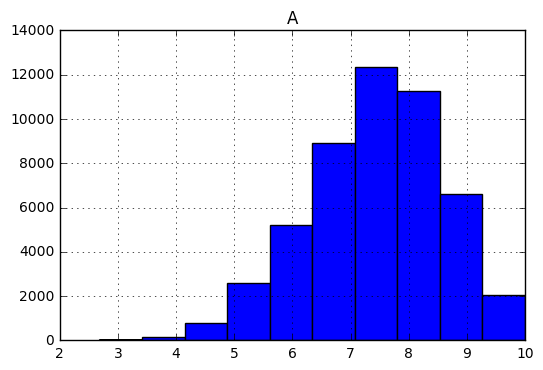

In [16]:
samples.hist(column='A');

### Exercise 3

1. Did the sampler estimate the right value for A?
2. How big is the error in its estimate of A?
3. We saw in the previous tutorial that estimating A is harder than estimating the frequency. Is the same true this time?

## Results

Let's look at our results in general. Using the `seaborn` package, we can create a nice set of pairwise plots for our parameters.

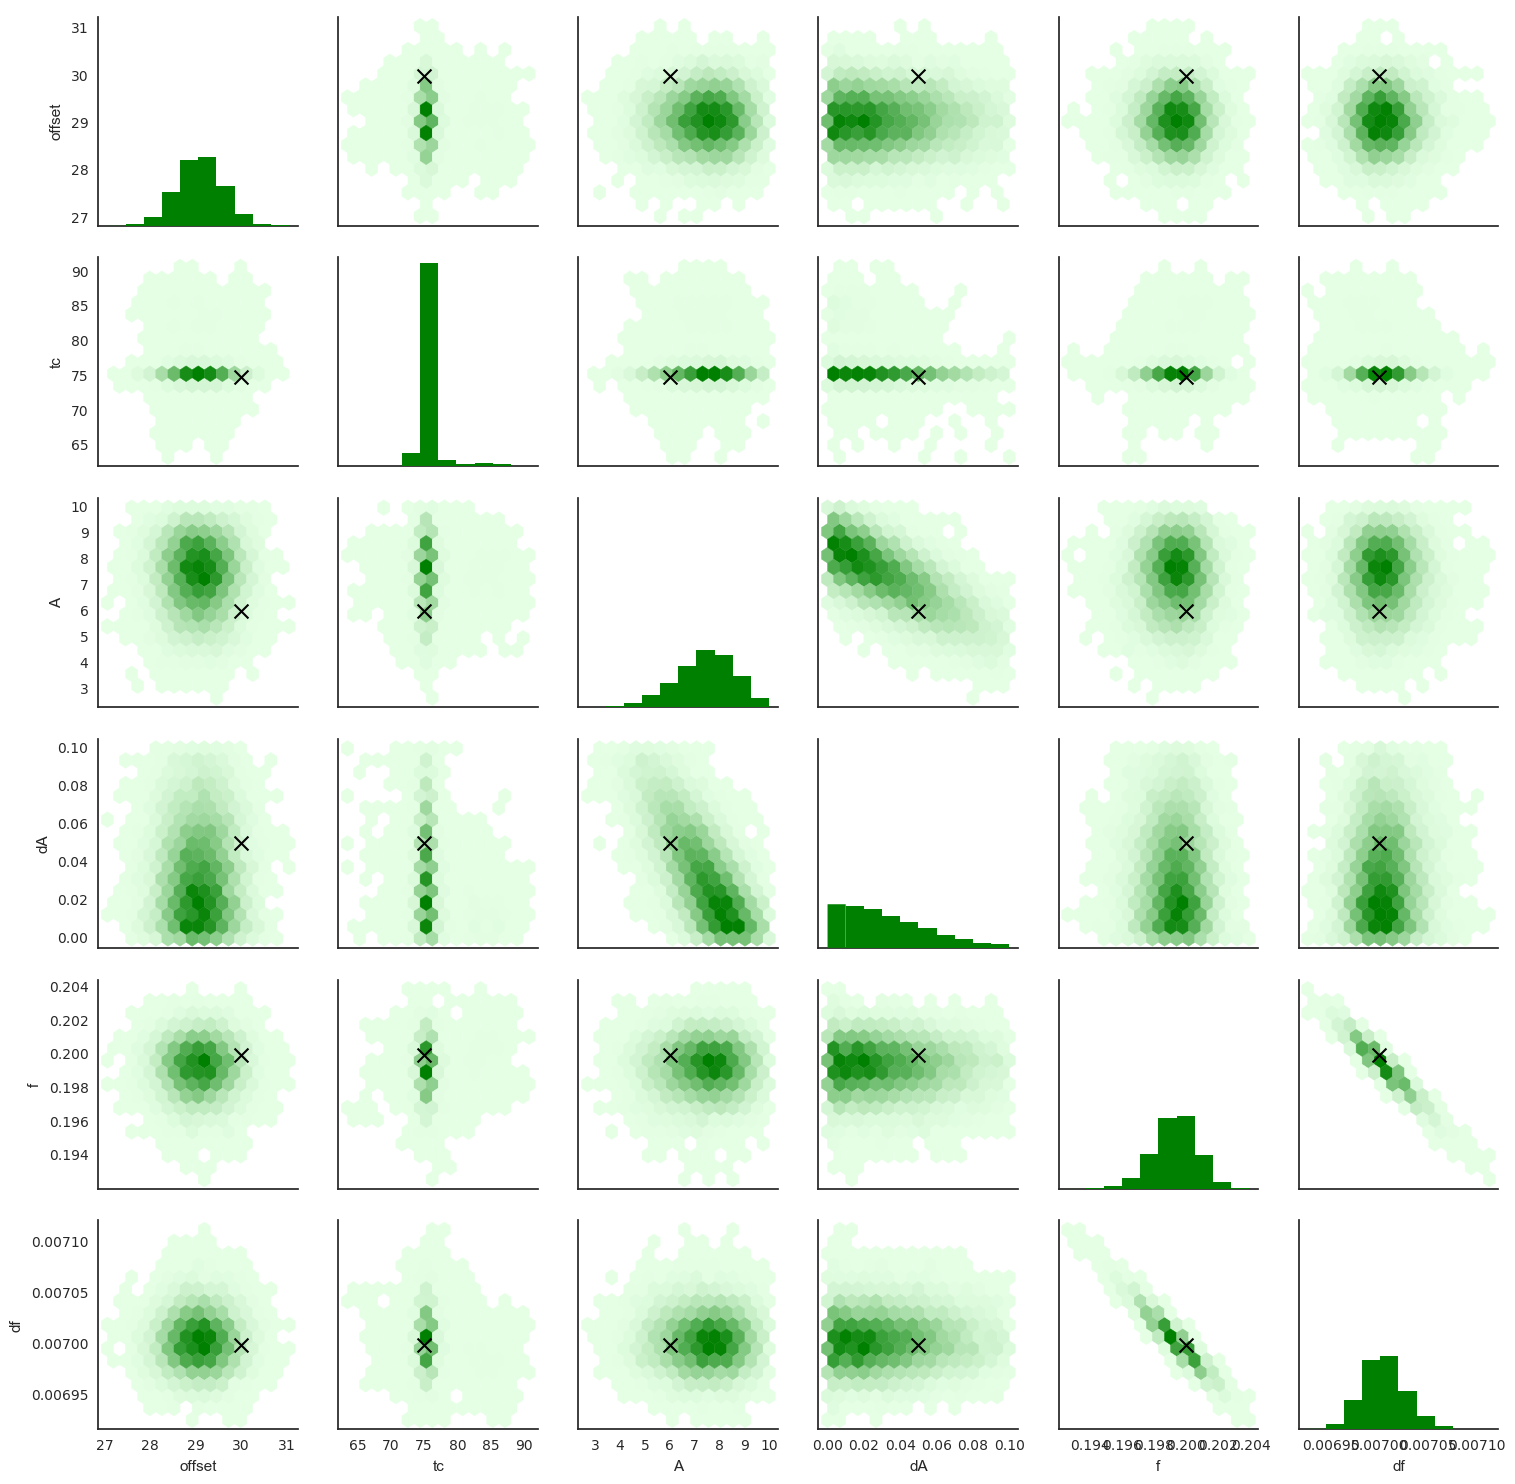

In [17]:
# Some settings for Seaborn
sns.set(style="ticks", color_codes=True)

# Wrapper function for the hexbin plotting style
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap = cmap, mincnt = 1)
    return

# Helper arrays
var_order = ['offset', 'tc', 'A', 'dA', 'f', 'df']
truth = [offset_true, tc_true, A_true, dA_true, f_true, df_true]
est = samples[var_order].max().values

# Plot a pairwise grid of scatter plots and histograms
with sns.axes_style("white"):
    g = sns.pairplot(
        samples[var_order],
        # We don't actually want the scatter plots, so we set
        # the marker size to 0
        plot_kws={"s": 0}, 
        diag_kws={'color': 'green', 'lw': 0}
    )
    
    # Replace the scatter plots with hexbin plots
    g.map_offdiag(hexbin, color='green');


# Plot the injected values in the histograms
for i in range(len(var_order)):
    for j in range(len(var_order)):
        if i != j:
            ax = g.axes[i,j]
            ax.scatter([truth[j]], [truth[i]], color = "black", marker = 'x', s=100, linewidths=1.5)

The pairwise scatterplots above give us a good idea of our results, showing us how well the parameters have been estimated, and making clear any correlations between the parameters. 

We see that `A` and `dA` have not been estimated very well. That's not a problem with our technique: the data simply doesn't contain the information we need to estimate them accurately. We also see they're correlated, as might be expected. Similarly, `f` and `df` show strong correlation: apparently it is difficult to estimate them both at the same time. However, the peak in each is quite close to the injected values.

### Exercise 4
1. The time of coalescence `tc` has been estimated very accurately, showing a sharp peak at the right value, and its estimate doesn't appear to be correlated with any other parameters. Can you explain why?
2. Why are `A`/`dA` and `f`/`df` negatively correlated?

## Concluding remarks

The massive challenge in gravitational wave detectors is that the signals are orders of magnitude smaller than the noise (even after a great deal of effort has been devoted to reducing that noise), but because it's possible to predict the shapes of signals from General Relativity, it becomes possible to dig them out.

The reality of the problem is much more complicated than the examples we have looked at. There are generally more parameters, meaning a higher-dimensional distribution to sample, and more noise. This means more advanced techniques are required, such as [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm). However, hopefully these two notebooks have given at least an idea of how matched filtering can be used to detect gravitational waves.

